# Implementing a 2D Simulation of Active Brownian Particles

In [1]:
#Imports

import sys
import os
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pdb #python debugger
from timeit import default_timer as timer #timer
from collections import OrderedDict
import argparse

sys.path.insert(1, '/Users/ryanlopez/ABPTutorial/c++') #Connects to ABP Folder github.com/ryanlopezzzz/ABPTutorial
from cppmd.builder import *
import cppmd as md

import read_data as rd #reads snapshot text data
import MSD #calculates MSD
import directories #used to create directories for saving data

# Folders

All research data is contained in a directory with path variable <em>save_dir</em>
<br>
<br>
Within <em>save_dir</em>, there are different sub-directories corresponding to different types of experiments, with path variable <em>exp_dir</em>
<br>
<br>
Within <em>exp_dir</em>, there are different sub-directories corresponding to different specific runs of the experiment, with path variable <em>run_dir</em>. These folders contain information about the specific run, and are named automatically by the date-time it was first run. Example: "2-24-2021--22-15-52" corresponds to 2/24/2021 at 10:15:52PM

In [2]:
#Directory where all data is saved
save_dir = "/Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/Saved_Data"

In [3]:
exp_folder_name = "flocking_transition_vary_Dr" #Folder name of experiment directory, don't change inbetween runs unless studying something different

load_date = None #Enter date in format 2-24-2021--22-15-52 (2/24/2021 at 10:15:52PM) to connect to previous run
#If load_date = None, will start new experiment

In [4]:
exp_dir, run_dir, snapshot_dir = directories.create(save_dir, exp_folder_name, load_date)

Successfully created the directory /Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/Saved_Data/flocking_transition_vary_Dr/4-14-2021--7-40-01 
Successfully created the directory /Users/ryanlopez/Desktop/Python_Programs/Dr_Marchetti_Research/Saved_Data/flocking_transition_vary_Dr/4-14-2021--7-40-01/snapshot_data/ 


## ABP Physics

ABPs are described by the coupled Langevin Equations:
<br>
<br>
$\dot{r}_i = v_0 \hat{n} + \mu \sum_j F_{ij} + \xi_i^t$
<br>
$\dot{\theta}_i = \xi_i^r$
<br>
<br>
Where both $\xi^t$ and $\xi^r$ are Gaussian white noise which satisfy:
<br>
<br>
$<\xi_i^t \xi_j^t> = 2D_t \delta_{ij}$
<br>
$<\xi_i^r \xi_j^r> = 2D_r \delta_{ij}$
<br>
<br>
The relevant physics of the ABPs is determined through 4 parameters:

$Pe_r = \frac{v_0}{D_r a}$ (Peclet number, $a$ is the particle's radius)
<br>
$\mu = 1$ (Particle Mobility)


### Dimensionless quantities I should use:
Packing fraction

Peclet Number $Pe_r = \frac{v_0 \tau_r}{a}=\frac{v_0}{D_r a}$

Time scale $\tau_k = \frac{1}{\mu k}$

Mobility $\mu = \frac{1}{\gamma_t}$

Fluctuation-Dissipation Theorem: $D_t = k T \mu$

In [21]:
#Physical parameters:

gamma_t = 1.0 #translational friction coefficient
gamma_r = 1.0 #rotational friction coefficient

alpha = 0.03 #Active self propulsion force, v_0 = alpha/gamma_t
kT = 0 #temperature of the system, typically set to zero

param_search = False

if not param_search:
    D_r = 0.6 #rotation diffusion coefficient
else:
    parser = argparse.ArgumentParser();
    parser.add_argument('--param', help='Varied parameter value for the run.', default=None)
    args = parser.parse_args()
    
    D_r = float(args.param)


#Calculate some parameters:
v0 = alpha/gamma_t #self propulsion speed
mu = 1/gamma_t #mobility
D_t = kT * mu #translational diffusion coefficient #this comes from Fluctuation-Dissipation Theorem
kT_rot = D_r * gamma_r #rotational temperature, see brownian_rot_integrator.py

#Box parameters:

phi = 0.5/np.pi #particle number density, phi = N/L^2 
L = 70 #Simulation box side length, makes square
radius = 1 #Radius of particles if poly=0 #In initial config, center of particles are not closer than a together?
poly = 0.3 #Implements polydispersity in particle, r_i = R * (1+ poly * uniform(-0.5, .0.5) )

Np = int(round(phi*L**2)) #number of particles
approx_packing = np.pi * radius**2 * Np / (L**2) #Note this is not true when poly =/= 0

#Optional Forces:
apply_soft_repulsive_force = True #applies soft harmonic force if particles are overlapping
k = 1 #spring constant for harmonic force
apply_velocity_alignment = True #Applies torque to each particle based on relative alignment with neighbors
J = 1

#Integration parameters:

warm_up_time = 1e4 #1e0 #Run simulation for this amount of time to reach steady state
tf = 5e3 #time to run simulation while logging physical quantities
tstep = 1e-1 #Time step size for integration
rand_seed = random.randint(1,10000) #random seed used for Brownian integration

warm_up_nsteps = int(warm_up_time / tstep)
nsteps = int(tf / tstep) #total number of time steps

print("Packing Fraction: " + str(approx_packing) + "\n")
print("Number of particles: " + str(Np) + "\n \n")
print("Orientational Correlation Time: " + str(1/D_r if D_r !=0 else "infinity") + "\n")
print("Interaction time: " + str(1/(mu*k))+"\n")
#print("Mean free time between collisions: " + str(L**2 /(2*radius*v0*Np)))

Packing Fraction: 0.500090259142865

Number of particles: 780
 

Orientational Correlation Time: 1.6666666666666667

Interaction time: 1.0



In [6]:
#creates random initial configuration, saves config to outfile
random_init(phi, L, radius = radius, rcut=0, poly = poly, outfile=os.path.join(run_dir, 'init.json'))

In [7]:
reader = md.fast_read_json(os.path.join(run_dir, 'init.json'))  #here we read the json file in c++
system = md.System(reader.particles, reader.box)

dump = md.Dump(system)          # Create a dump object

evolver = md.Evolver(system)    # Create a system evolver object

#add the forces and torques

# Create pairwise repulsive interactions with the spring contant k = 10 and range a = 2.0
if apply_soft_repulsive_force:
    evolver.add_force("Soft Repulsive Force", {"k": k})
    #evolver.add_force("Harmonic Force", {"k": k})
    
# Create self-propulsion, self-propulsion strength alpha
evolver.add_force("Self Propulsion", {"alpha": alpha})

# Create pairwise polar alignment with alignment strength J = 1.0 and range a = 2.0
if apply_velocity_alignment:
    evolver.add_torque("Velocity Align", {"k": J})

#Add integrators

# Integrator for updating particle position, friction gamma = 1.0 , "random seed" seed = 10203 and no thermal noise
evolver.add_integrator("Brownian Positions", {"T": kT, "gamma": gamma_t, "seed": rand_seed})

# Integrator for updating particle orientation, friction gamma = 1.0, "rotation" T = 0.1, D_r = 0.0, "random seed" seed = 10203
evolver.add_integrator("Brownian Rotation", {"T": kT_rot, "gamma": gamma_r, "seed": rand_seed})

evolver.set_time_step(tstep) # Set the time step for all the integrators


In [8]:
#warms up simulation to reach steady state
for t in range(warm_up_nsteps):
    evolver.evolve()
print("Warm up time complete")

Warm up time complete


In [9]:
total_snapshots = 100 #total number of snapshots to save
print("Saving observables every %s time steps"%(int(nsteps/total_snapshots)))

#simulation while logging quantities:
for t in range(nsteps):
    if t % int(nsteps/10) == 0:
        print("Time step : ", t)
    evolver.evolve()    # Evolve the system by one time step
    if t % int(nsteps/total_snapshots) == 0:     #Save snapshot of the observable data
        snapshot_file_path = os.path.join(snapshot_dir, 'snapshot_{:08d}.txt'.format(t))
        dump.dump_data(snapshot_file_path) #Saves data in .txt file
        snapshot_file_path = os.path.join(snapshot_dir, 'snapshot_{:08d}.vtp'.format(t))
        dump.dump_vtp(snapshot_file_path) #Saves data in .vtp file for visualization
print("done")

Saving observables every 500 time steps
Time step :  0
Time step :  5000
Time step :  10000
Time step :  15000
Time step :  20000
Time step :  25000
Time step :  30000
Time step :  35000
Time step :  40000
Time step :  45000
done


In [10]:
def get_flocking_factors(exp_data, v0):
    #vicsek_param = | \sum \vec{n}_i / N |
    nx_data = exp_data['nx'] #shape: [num of time snapshots, num of particles]
    ny_data = exp_data['ny']
    
    Np = nx_data.shape[1] #number of particles
    
    vicsek_param_nx = np.sum(nx_data, axis=1) / Np
    vicsek_param_ny = np.sum(ny_data, axis=1) / Np
    
    vicsek_param = vicsek_param_nx**2 + vicsek_param_ny**2
    
    #vel_param = | \sum \vec{v}_i / (N * v0) |
    
    vx_data = exp_data['vx'] #shape: [num of time snapshots, num of particles]
    vy_data = exp_data['vy']
    
    vel_param_nx = np.sum(vx_data, axis=1) / (Np * v0)
    vel_param_ny = np.sum(vy_data, axis=1) / (Np * v0)
    
    vel_param = vel_param_nx**2 + vel_param_ny**2
    
    return vicsek_param, vel_param

In [11]:
exp_data = rd.get_exp_data(snapshot_dir)

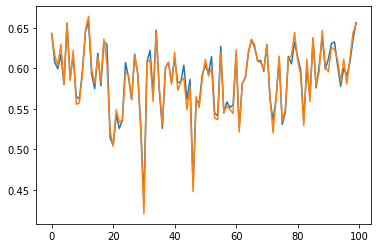

In [12]:
vicsek_param, vel_param = get_flocking_factors(exp_data, v0)

plt.plot(vicsek_param)
plt.plot(vel_param)

In [13]:
np.average(vel_param)
np.average(vicsek_param)

0.588375961936044

In [14]:
run_desc = OrderedDict()

run_desc['gamma_t'] = gamma_t
run_desc['gamma_r'] = gamma_r
run_desc['alpha'] = alpha
run_desc['kT'] = kT
run_desc['D_r'] = D_r
run_desc['v0'] = v0
run_desc['mu'] = mu
run_desc['D_t'] = D_t
run_desc['kT_rot'] = kT_rot
run_desc['phi'] = phi
run_desc['L'] = L
run_desc['radius'] = radius
run_desc['poly'] = poly
run_desc['Np'] = Np
run_desc['approx_packing'] = approx_packing
run_desc['k'] = k
run_desc['J'] = J
run_desc['warm_up_time'] = warm_up_time
run_desc['tf'] = tf
run_desc['tstep'] = tstep
run_desc['rand_seed'] = rand_seed
run_desc['warm_up_nsteps'] = warm_up_nsteps
run_desc['nsteps'] = nsteps

run_desc['vicsek_param'] = np.average(vicsek_param)
run_desc['vel_param'] = np.average(vel_param)


run_desc_file = open(os.path.join(run_dir, "run_desc.json"), 'w')
run_desc_file.write(json.dumps(run_desc))
run_desc_file.close()

In [15]:
"""
#get position data from snapshots
position_data = rd.get_position_data(snapshot_dir) #shape [num of time snapshots, num of particles, (2) spatial dims]
"""

'\n#get position data from snapshots\nposition_data = rd.get_position_data(snapshot_dir) #shape [num of time snapshots, num of particles, (2) spatial dims]\n'

Theoretical predictions for MSD is (see "Minimal model of active colloids highlights the role of mechanical
interactions...")
<br>
<br>
$<\Delta r(t)^2> = 4D_t t + 2v_0^2 \tau_r [t-\tau_r (1-exp(-t/\tau_r))]$

<br>
Note the definition that $\tau_r = 1/D_r$.

In [16]:
"""
#Calculate theoretical MSD:

times = np.linspace(0,tf,num=total_snapshots-1)
tau_r = 1/D_r
MSD_theory = 4*D_t*times+2*(v0**2)*tau_r*(times-tau_r*(1-np.exp(-times/tau_r)))
"""

'\n#Calculate theoretical MSD:\n\ntimes = np.linspace(0,tf,num=total_snapshots-1)\ntau_r = 1/D_r\nMSD_theory = 4*D_t*times+2*(v0**2)*tau_r*(times-tau_r*(1-np.exp(-times/tau_r)))\n'

Experimental MSD can be calculated from displacement, so I consider the difference in positions at each time step. The periodic boundary conditions must be accounted for. I make the assumption the in 1 time step the particle will never traverse more than half of the boxes length in any dimension (or else actual displacement becomes unclear). The formula used for displacement in the x dimension $D_x$ going from position $x_i$ to $x_f$ is:
<br>
<br>
$D_x = \left[ \left(x_f-x_i+\frac{3L_x}{2} \right)\% L_x \right] - \frac{L_x}{2} $
<br>
<br>
Where $\%$ denotes the modulo operator. This formula can be verified by checking all cases. Same formula for y dimension.

In [17]:
"""
#Calculate MSD from Simulation: 
MSD_sim_ensemble, MSD_sim = MSD.get_MSD_sim_data(position_data, L)
"""

'\n#Calculate MSD from Simulation: \nMSD_sim_ensemble, MSD_sim = MSD.get_MSD_sim_data(position_data, L)\n'

In [18]:
"""
#Plot various MSD:

#matplotlib inline
caption=r"MSD study for Active Brownian Particles with no interactions. Ensemble consists of %d Particles. Parameters are $D_r = %.3f, D_t = %.2f, \mu=%.1f, v_0=%.3f$."%(Np,D_r,D_t,mu,v0)             

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(times, MSD_theory, color = "blue", label='Theory MSD')
ax.plot(times, MSD_sim_ensemble, color = "red", label='Ensemble MSD')
ax.plot(times, MSD_sim.T[0], color = "purple", label='Single Particle MSD')
plt.yscale('log')
plt.xscale('log')

ax.set(xlabel='time (s)', ylabel=r'$<\Delta r^2>$',
       title='Various MSD')
ax.legend()

fig.text(.5, -.05, caption, ha='center', fontsize=12)
plt.show()
"""

'\n#Plot various MSD:\n\n#matplotlib inline\ncaption=r"MSD study for Active Brownian Particles with no interactions. Ensemble consists of %d Particles. Parameters are $D_r = %.3f, D_t = %.2f, \\mu=%.1f, v_0=%.3f$."%(Np,D_r,D_t,mu,v0)             \n\nfig, ax = plt.subplots(figsize=(14,7))\nax.plot(times, MSD_theory, color = "blue", label=\'Theory MSD\')\nax.plot(times, MSD_sim_ensemble, color = "red", label=\'Ensemble MSD\')\nax.plot(times, MSD_sim.T[0], color = "purple", label=\'Single Particle MSD\')\nplt.yscale(\'log\')\nplt.xscale(\'log\')\n\nax.set(xlabel=\'time (s)\', ylabel=r\'$<\\Delta r^2>$\',\n       title=\'Various MSD\')\nax.legend()\n\nfig.text(.5, -.05, caption, ha=\'center\', fontsize=12)\nplt.show()\n'

In [19]:
#### Plots the particles in the box
#%matplotlib widget
#dump.show(notebook=True)